In [1]:
import cv2 as cv
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import time

SZ=20
bin_n = 16 # Number of bins

Path = 'D:\Schule\PREN\Bilder'
TrainingImg = '\digits.png'
TestImg = '\ZahlenSchwarzAufWeiss.jpg'

affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR

## [deskew]
def deskew(img):
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]

## [hog]
def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)
    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector

    # transform to Hellinger kernel
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= norm(hist) + eps
    return hist
## [hog]

img = cv.imread(Path+TrainingImg,0)
if img is None:
    raise Exception("we need the digits.png image from samples/data here !")

img = img
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]

# First half is trainData, remaining is testData
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]

######     Now training      ########################

deskewed = [list(map(deskew,row)) for row in train_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
trainData = np.float32(hogdata).reshape(-1,64)
responses = np.repeat(np.arange(10),250)[:,np.newaxis]

svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

svm.train(trainData, cv.ml.ROW_SAMPLE, responses)
svm.save('svm_data.dat')

######     Now testing      ########################

deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict(testData)[1]

#######   Check Accuracy   ########################
mask = result==responses
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

95.92


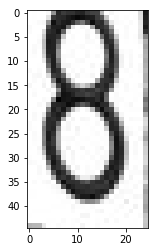

[[8.]]
0.0578765869140625


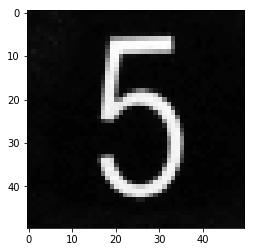

[[5.]]
0.058809518814086914


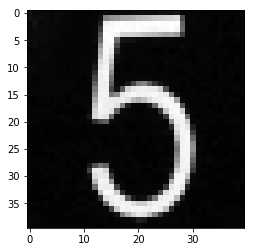

[[5.]]
0.06383037567138672


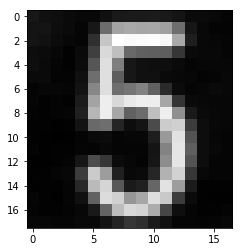

[[5.]]
0.06482625007629395


In [4]:
######  Test mit eigenden Bilder ####################
starttime = time.time()
newimg = cv.imread(Path+TestImg,0)
zahl = newimg[100:145, 265:290]
plt.imshow(zahl,'gray')
plt.show()
#zahl = cv.medianBlur(zahl,5)
#thresh = cv.adaptiveThreshold(zahl,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
#ret,thresh = cv.threshold(zahl,127,255,cv.THRESH_BINARY)
#plt.imshow(thresh)
thresh = cv.resize(zahl,(20,20))
#ret,thresh = cv.threshold(thresh,127,255,cv.THRESH_BINARY)
##plt.imshow(thresh)
##plt.show()
##print(thresh)
desk = deskew(thresh)
hData = hog(desk)
tData = np.float32(hData).reshape(-1,bin_n*4)
print(svm.predict(tData)[1])
print(time.time()-starttime)

starttime = time.time()
newimg = cv.imread('images/image2_w640_h480_iso100_exsports.jpg',0)
zahl = newimg[130:180,295:345]
plt.imshow(zahl,'gray')
plt.show()
thresh = cv.resize(zahl,(20,20))
#desk = deskew(thresh)
hData = hog(thresh)
tData = np.float32(hData).reshape(-1,bin_n*4)
print(svm.predict(tData)[1])
print(time.time()-starttime)

starttime = time.time()
newimg = cv.imread('images/image2_w640_h480_iso100_exsports.jpg',0)
zahl = newimg[135:175,300:340]
plt.imshow(zahl,'gray')
plt.show()
thresh = cv.resize(zahl,(20,20))
#desk = deskew(thresh)
hData = hog(thresh)
tData = np.float32(hData).reshape(-1,bin_n*4)
print(svm.predict(tData)[1])
print(time.time()-starttime)

starttime = time.time()
newimg = cv.imread('images/test_run2/big/imageFromWeb_008.jpg',0)
zahl = newimg[235:253,268:285]
plt.imshow(zahl,'gray')
plt.show()
thresh = cv.resize(zahl,(20,20))
#desk = deskew(thresh)
hData = hog(thresh)
tData = np.float32(hData).reshape(-1,bin_n*4)
print(svm.predict(tData)[1])
print(time.time()-starttime)